In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv(
    "e-commerce-shoppers-behaviour-understanding/train_data_v2.csv"
)

In [3]:
cat_features = [col for col in train_data.columns if train_data[col].dtype == object]
print("Total categorical features:", len(cat_features))
num_features = [
    col for col in train_data.columns if train_data[col].dtype not in (object, bool)
]
print("Total numerical features:", len(num_features))

Total categorical features: 6
Total numerical features: 15


In [4]:
feature = train_data.iloc[:, :-1]
label = train_data.iloc[:, -1]

In [5]:
num_features = [_ for _ in num_features if _ not in ('GoogleMetric:Exit Rates', 'ProductDesciptionPage', 'LandingPage')]
num_features

['HomePage',
 'HomePage_Duration',
 'LandingPage_Duration',
 'ProductDescriptionPage',
 'ProductDescriptionPage_Duration',
 'GoogleMetric:Bounce Rates',
 'GoogleMetric:Page Values',
 'SeasonalPurchase',
 'OS',
 'SearchEngine',
 'Zone',
 'Type of Traffic',
 'WeekendPurchase']

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [8]:
num_pipeline = Pipeline([("imputer", IterativeImputer()), ("scaler", StandardScaler())])

cat_pipeline = Pipeline(
    [
        ("encoder", OneHotEncoder()),
    ]
)

In [9]:
preprocessing_pipe = ColumnTransformer(
    [("num", num_pipeline, num_features), ("cat", cat_pipeline, cat_features)],
)

In [10]:
l_enc = LabelEncoder()
label = l_enc.fit_transform(label)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.2)

In [27]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [13]:
X_train_pre = preprocessing_pipe.fit_transform(X_train)

# Classifier 1 using imblearn combine method
### Captures 1's better

In [15]:
over_under = SMOTETomek()
X_train_comb, y_train_comb = over_under.fit_resample(X_train_pre, y_train)

In [35]:
estimators = [
    ("rf", RandomForestClassifier(n_estimators=500, max_features="log2", random_state=42)),
    (
        "gb",
        GradientBoostingClassifier(
            warm_start=True,
            tol=0.0001,
            n_iter_no_change=5,
            n_estimators=200,
            min_samples_split=4,
            min_samples_leaf=1,
            max_features=None,
            max_depth=3,
            loss="log_loss",
            learning_rate=0.015,
            criterion="friedman_mse",
        ),
    ),
    (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
        ),
    ),
    (
        "svc",
        SVC(C=10, degree=2, gamma=0.01, kernel="rbf", probability=True),
    ),
    ("nb", BernoulliNB()),
    ("nc", NearestCentroid())
]

In [36]:
clf1 = StackingClassifier(
            estimators=estimators,
            final_estimator=AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=2),
                learning_rate=0.05,
            ),
            passthrough=True,
            stack_method="auto",
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            n_jobs=-1,
        )

In [37]:
clf1.fit(X_train_comb, y_train_comb)

StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x2AA78112340, shuffle=True),
                   estimators=[('rf',
                                RandomForestClassifier(max_features='log2',
                                                       n_estimators=500,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.015,
                                                           min_samples_split=4,
                                                           n_estimators=200,
                                                           n_iter_no_change=5,
                                                           warm_start=True)),
                               ('logit',
                                LogisticRegression(C=0.1, max_iter=2000,
                                                   multi_class='multinomial',
                                                   solver='saga')),
                               ('svc',
                                SVC(C=10, degree=2, gamma=0.01,
                                    probability=True)),
                               ('nb', BernoulliNB()),
                               ('nc', NearestCentroid())],
                   final_estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                      learning_rate=0.05),
                   n_jobs=-1, passthrough=True)

In [38]:
X_val_pre = preprocessing_pipe.fit_transform(X_val)

In [ ]:
y_val_hat_predict_1 = clf1.predict(X_val_pre)

In [39]:
clf1.score(X_val_pre, y_val)

0.39769256871394637

In [40]:
print(classification_report(y_val, y_val_hat_predict_1, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1775
           1       0.40      1.00      0.57      1172

    accuracy                           0.40      2947
   macro avg       0.20      0.50      0.28      2947
weighted avg       0.16      0.40      0.23      2947



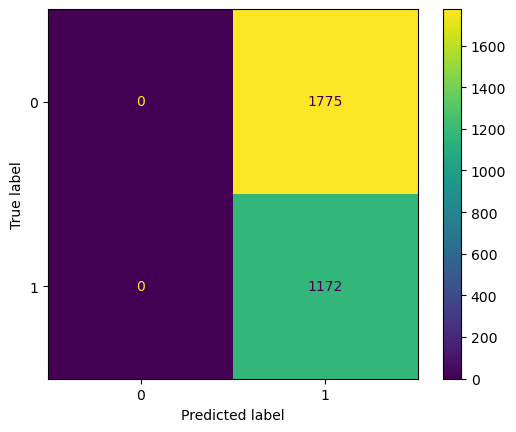

In [41]:
fig = ConfusionMatrixDisplay.from_predictions(y_val, y_val_hat_predict_1)
plt.show()

# Classifier 2 without using Imblearn
### Captures 0's better

In [68]:
estimators = [
    ("rf", RandomForestClassifier(n_estimators=500, max_features="log2", random_state=42)),
    (
        "gb",
        GradientBoostingClassifier(
            warm_start=True,
            tol=0.0001,
            n_iter_no_change=5,
            n_estimators=200,
            min_samples_split=4,
            min_samples_leaf=1,
            max_features=None,
            max_depth=3,
            loss="log_loss",
            learning_rate=0.015,
            criterion="friedman_mse",
        ),
    ),
    (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
        ),
    ),
    # (
    #     "svc",
    #     SVC(C=10, degree=2, gamma=0.01, kernel="rbf", probability=True),
    # ),
    ("nb", BernoulliNB()),
    ("nc", NearestCentroid())
]

In [69]:
clf2 = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
            "stacking",
            StackingClassifier(
                estimators=estimators,
                final_estimator=AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth=2),
                    learning_rate=0.05,
                ),
                passthrough=True,
                stack_method="auto",
                cv=StratifiedKFold(n_splits=5, shuffle=True),
                n_jobs=-1,
            ),
        ),
    ]
)

In [70]:
clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEng...
                                                 GradientBoostingClassifier(learning_rate=0.015,
                                                                            min_samples_split=4,
                                                                            n_estimators=200,
                                                                            n_iter_no_change=5,
                                                                            warm_start=True)),
                                                ('logit',
                                                 LogisticRegression(C=0.1,
                                                                    max_iter=2000,
                                                                    multi_class='multinomial',
                                                                    solver='saga')),
                                                ('nb', BernoulliNB()),
                                                ('nc', NearestCentroid())],
                                    final_estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                                       learning_rate=0.05),
                                    n_jobs=-1, passthrough=True))])

In [71]:
clf2.score(X_val, y_val)

0.7641669494401085

In [72]:
y_val_hat_predict_2 = clf2.predict(X_val)

In [73]:
print(classification_report(y_val, y_val_hat_predict_2, zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1775
           1       0.76      0.59      0.67      1172

    accuracy                           0.76      2947
   macro avg       0.76      0.74      0.74      2947
weighted avg       0.76      0.76      0.76      2947



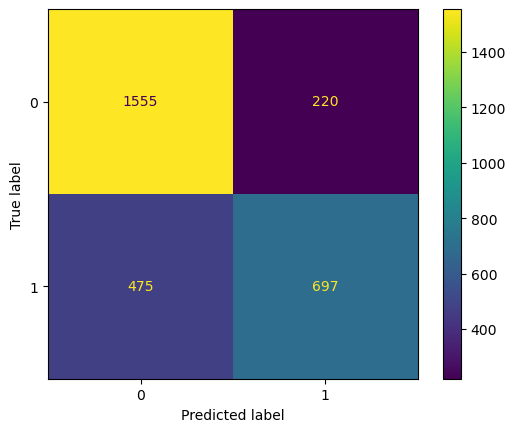

In [74]:
fig = ConfusionMatrixDisplay.from_predictions(y_val, y_val_hat_predict_2)
plt.show()

# Aggregating both clf1 and clf2

In [187]:
predict_proba_1 = clf1.predict_proba(X_val_pre)
predict_proba_2 = clf2.predict_proba(X_val)

In [204]:
weighted_proba_test = (predict_proba_1 + 22 * predict_proba_2) / 23

In [205]:
weighted_proba_test

array([[0.57149612, 0.42850388],
       [0.30014391, 0.69985609],
       [0.46691292, 0.53308708],
       ...,
       [0.7275884 , 0.2724116 ],
       [0.59606817, 0.40393183],
       [0.33901607, 0.66098393]])

In [206]:
y_pred = np.argmax(weighted_proba_test, axis=1)

In [207]:
print(classification_report(y_val, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7771    0.8563    0.8148      1775
           1     0.7427    0.6280    0.6805      1172

    accuracy                         0.7655      2947
   macro avg     0.7599    0.7422    0.7477      2947
weighted avg     0.7634    0.7655    0.7614      2947



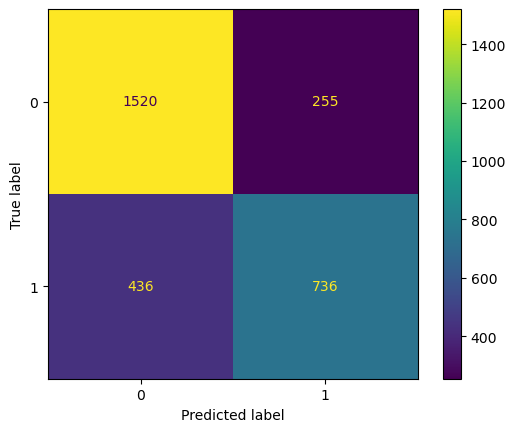

In [208]:
fig = ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

In [183]:
final_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    learning_rate=0.05,
)

In [170]:
predict_proba_1_train = clf1.predict_proba(X_train_pre)
predict_proba_2_train = clf2.predict_proba(X_train)

In [174]:
data_proba_train = np.concatenate((predict_proba_1_train, predict_proba_2_train), axis = 1)

In [175]:
data_proba_train

array([[0.5711163 , 0.4288837 , 0.59377109, 0.40622891],
       [0.57021121, 0.42978879, 0.59377109, 0.40622891],
       [0.48142052, 0.51857948, 0.44484412, 0.55515588],
       ...,
       [0.59747272, 0.40252728, 0.59377109, 0.40622891],
       [0.57021121, 0.42978879, 0.59199777, 0.40800223],
       [0.38465745, 0.61534255, 0.44484412, 0.55515588]])

In [177]:
data_proba_test = np.concatenate((predict_proba_1, predict_proba_2), axis = 1)

In [178]:
data_proba_test

array([[0.10932535, 0.89067465, 0.59250388, 0.40749612],
       [0.10121957, 0.89878043, 0.30918593, 0.69081407],
       [0.35582374, 0.64417626, 0.47196243, 0.52803757],
       ...,
       [0.11181218, 0.88818782, 0.75557823, 0.24442177],
       [0.10121957, 0.89878043, 0.61856129, 0.38143871],
       [0.20536819, 0.79463181, 0.34509098, 0.65490902]])

In [181]:
final_clf.fit(data_proba_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.05)

In [182]:
final_clf.score(data_proba_test, y_val)

0.3837801153715643

In [185]:
weighted_proba_train = (predict_proba_1_train + 21 * predict_proba_2_train) / 22

In [186]:
final_clf.fit(weighted_proba_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.05)

In [189]:
final_clf.score(weighted_proba_test, y_val)

0.49847302341364097